# A Short Introduction to Time Series Forecasting

In [728]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
import statsmodels.api as smt

# import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse
# OS
from pathlib import Path

# Styling
color_pal = sns.color_palette("Set2")
plt.style.use('seaborn-v0_8-colorblind') 

# Warnings control
import warnings 
warnings.filterwarnings('ignore')



In [729]:
data_path = Path('price/INTC.csv') # Update your path here

In [730]:
df = pd.read_csv(data_path, header=0)

### A quick look at the dataframe

In [731]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [732]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-04,25.030001,25.059999,24.270000,24.420000,20.711935,40688000
1,2012-09-05,24.400000,24.780001,24.190001,24.389999,20.686487,38595800
2,2012-09-06,24.469999,25.100000,24.459999,25.100000,21.288677,40187600
3,2012-09-07,24.129999,24.700001,24.010000,24.190001,20.516853,86282100
4,2012-09-10,23.950001,24.600000,23.170000,23.260000,19.728077,80584600


### Data Cleaning

Steps undertaken:
- set index
- typecast

In [733]:
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)

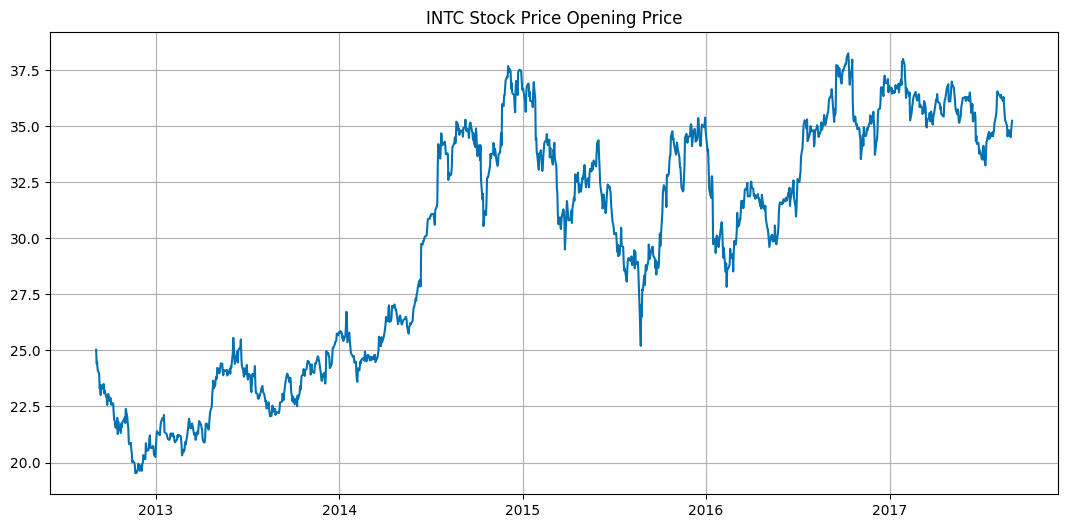

In [734]:
plt.show()
plt.figure(figsize=(13,6))
plt.plot(df.index,df['Open'])
plt.title('INTC Stock Price Opening Price')
plt.grid()
plt.show()

<Axes: ylabel='Frequency'>

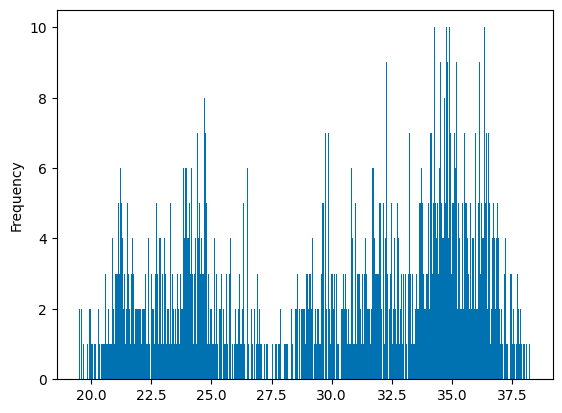

In [735]:
df['Open'].plot(kind='hist', bins=500) # Opening prices are not normal

In [736]:
df['Pct Change'] = df['Close'].pct_change() * 100

In [737]:
df.describe()


,Open,High,Low,Close,Adj Close,Volume,Pct Change
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1257.000000
mean,29.985676,30.247194,29.738593,30.005238,27.957586,3.103016e+07,0.038205
std,5.370144,5.400717,5.331414,5.374578,6.033379,1.618260e+07,1.368211
min,19.520000,19.549999,19.230000,19.360001,16.589478,5.893800e+06,-9.102021
25%,24.542500,24.742500,24.400000,24.542500,21.852218,2.092898e+07,-0.684556
50%,31.430000,31.760000,31.200001,31.500000,29.652850,2.708505e+07,0.062076
75%,34.750000,34.959999,34.497501,34.750000,33.353392,3.539780e+07,0.751880
max,38.250000,38.450001,37.900002,38.099998,37.153412,1.437604e+08,9.271533


In [738]:
df['Pct Change']


Date
2012-09-04         NaN
2012-09-05   -0.122854
2012-09-06    2.911033
2012-09-07   -3.625494
2012-09-10   -3.844568
                ...   
2017-08-28   -0.057675
2017-08-29    0.230874
2017-08-30    0.460694
2017-08-31    0.515910
2017-09-01    0.057029
Name: Pct Change, Length: 1258, dtype: float64

 ### Percent change is relatively more normally distributed

<Axes: ylabel='Frequency'>

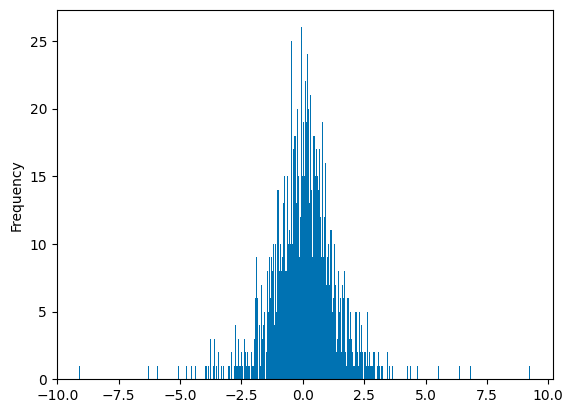

In [739]:
df['Pct Change'].plot(kind='hist', bins=500)

## Train Test Split

We set the train set before 2016, while 2016 to 2017 data is the test set.

In [740]:
train = df.loc[df.index < '2015-07-01']
test = df.loc[df.index >= '2015-07-01']


In [741]:
train

,Open,High,Low,Close,Adj Close,Volume,Pct Change
Date,,,,,,,
2012-09-04,25.030001,25.059999,24.270000,24.420000,20.711935,40688000,NaN
2012-09-05,24.400000,24.780001,24.190001,24.389999,20.686487,38595800,-0.122854
2012-09-06,24.469999,25.100000,24.459999,25.100000,21.288677,40187600,2.911033
2012-09-07,24.129999,24.700001,24.010000,24.190001,20.516853,86282100,-3.625494
2012-09-10,23.950001,24.600000,23.170000,23.260000,19.728077,80584600,-3.844568
...,...,...,...,...,...,...,...
2015-06-24,32.150002,32.150002,31.879999,31.910000,29.759979,23313900,-0.560922
2015-06-25,32.020000,32.320000,31.990000,31.990000,29.834587,22743300,0.250705
2015-06-26,31.510000,31.530001,30.760000,31.020000,28.929943,62157200,-3.032198


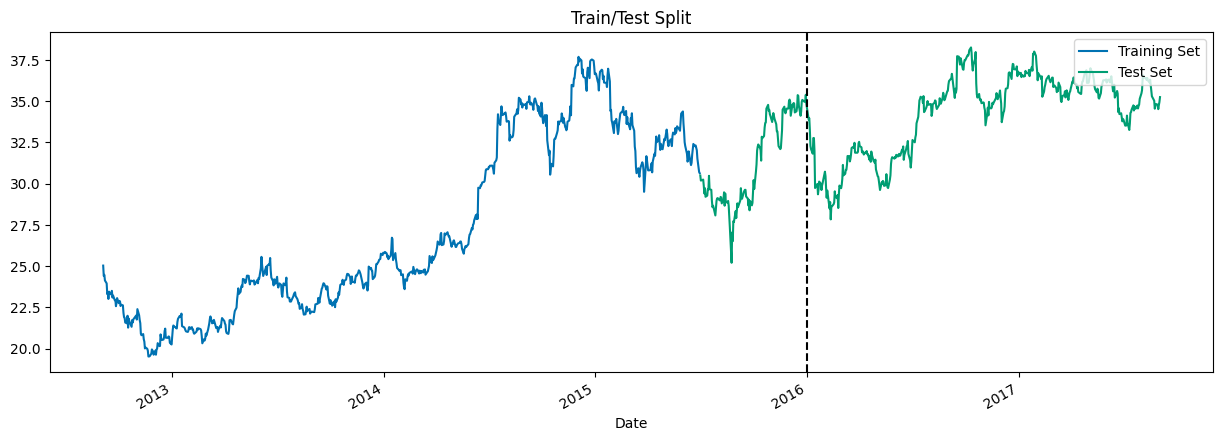

In [742]:
fig, ax = plt.subplots(figsize=(15,5))

train['Open'].plot(ax=ax, label='Train', title='Train/Test Split')
test['Open'].plot(ax=ax, label='Test')
ax.axvline('01-01-2016', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'], loc='upper right')
plt.show()

<Axes: title={'center': '10 Days of Data'}, xlabel='Date'>

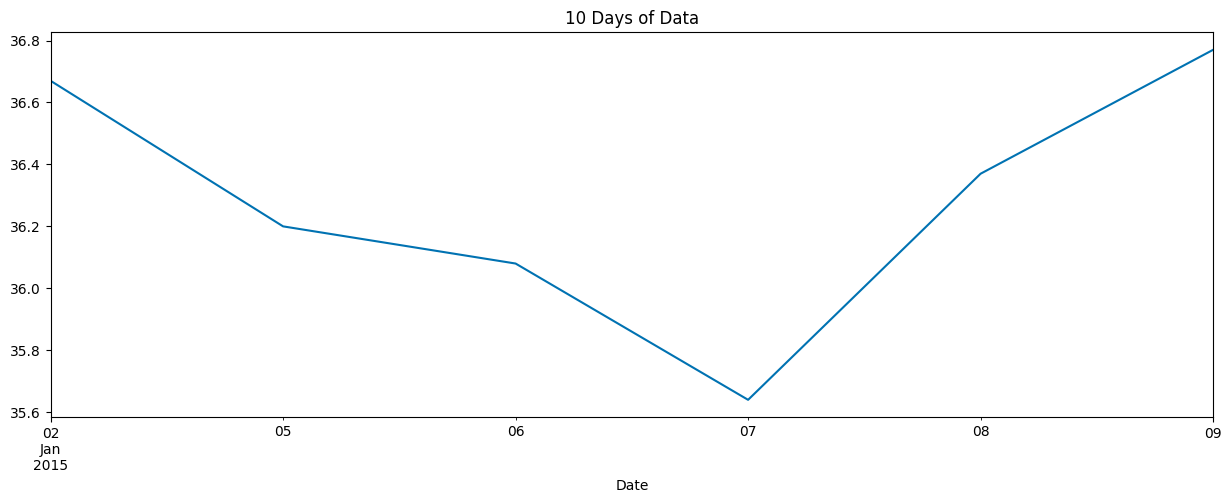

In [743]:
# visualising one week
df['Open'].loc[(df.index >'01-01-2015') & (df.index < '01-11-2015')] \
    .plot(figsize=(15,5), title='10 Days of Data') # note & denotes element-wise logical, whereas 'and' will ask python to typecast into bool

In [744]:
openp = df[['Open']].copy()  
openp.reset_index(inplace=True)  
openp.columns = ['Date', 'Open'] 

openp


,Date,Open
0,2012-09-04,25.030001
1,2012-09-05,24.400000
2,2012-09-06,24.469999
3,2012-09-07,24.129999
4,2012-09-10,23.950001
...,...,...
1253,2017-08-28,34.779999
1254,2017-08-29,34.509998
1255,2017-08-30,34.750000
1256,2017-08-31,34.939999


In [745]:
df.reset_index(inplace=True) 
price_df = pd.DataFrame({
    'Date': df['Date'],
    'Price': df['Open']
})
price_df['Date'] = pd.to_datetime(price_df['Date'])


In [746]:
price_df

,Date,Price
0,2012-09-04,25.030001
1,2012-09-05,24.400000
2,2012-09-06,24.469999
3,2012-09-07,24.129999
4,2012-09-10,23.950001
...,...,...
1253,2017-08-28,34.779999
1254,2017-08-29,34.509998
1255,2017-08-30,34.750000
1256,2017-08-31,34.939999


# Model Processing

## only time series

In [747]:
# import numpy as np
# import pandas as pd
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.metrics import mean_absolute_percentage_error
# import matplotlib.pyplot as plt

# # 确保 openp 已经存在，并且 Date 列已经转换为日期格式
# openp['Date'] = pd.to_datetime(openp['Date'])
# openp.set_index('Date', inplace=True)

# # 创建更多时间特征
# openp['Year'] = openp.index.year
# openp['Month'] = openp.index.month
# openp['Day'] = openp.index.day
# openp['Weekday'] = openp.index.weekday  # 周几
# openp['Quarter'] = openp.index.quarter  # 季度

# # 特征和目标
# X = openp[['Year', 'Month', 'Day', 'Weekday', 'Quarter']]
# y = openp['Open']

# # 10折交叉验证
# tscv = TimeSeriesSplit(n_splits=100)
# mape_list = []

# # 设置绘图
# plt.figure(figsize=(15, 7))
# plt.plot(openp.index, openp['Open'], label='Actual Price', color='blue', linewidth=2)

# # Expanding Window 交叉验证
# for train_index, test_index in tscv.split(openp):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     # 使用随机森林模型
#     model = RandomForestRegressor(n_estimators=100, random_state=42)
#     model.fit(X_train, y_train)
    
#     # 预测
#     predictions = model.predict(X_test)
    
#     # 计算 MAPE
#     mape_error = mean_absolute_percentage_error(y_test, predictions)
#     mape_list.append(mape_error)
    
#     # 绘制预测值（使用折线图）
#     plt.plot(openp.index[test_index], predictions, color='red', alpha=0.5, linewidth=2)

# # 输出整体 MAPE
# mean_mape = np.mean(mape_list)
# print(f'Mean MAPE: {mean_mape:.4f}')

# # 添加标题和标签
# plt.title(f'Random Forest Predictions vs Actual Prices\nOverall MAPE: {mean_mape:.4f}', fontsize=16)
# plt.xlabel('Date', fontsize=14)
# plt.ylabel('Price', fontsize=14)
# plt.legend()
# plt.grid()
# plt.show()


## X --sentiment

### XGBOOST

In [748]:
sentiment_df = pd.read_csv('./sentiment_data.csv')
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])
merged_data = pd.merge(price_df, sentiment_df, left_on='Date', right_on='Date', how='inner')

merged_data['Sentiment'] = merged_data['Sentiment'].replace({'POS': 1, 'NEG': -1, 'NEU': 0})


In [749]:
merged_data

,Date,Price,Sentiment
0,2014-01-02,25.780001,0
1,2014-01-03,25.860001,1
2,2014-01-06,25.770000,0
3,2014-01-07,25.540001,1
4,2014-01-08,25.639999,1
...,...,...,...
408,2015-12-24,35.070000,1
409,2015-12-28,34.950001,0
410,2015-12-29,35.009998,1
411,2015-12-30,35.380001,1


In [750]:
merged_data.set_index('Date', inplace=True)


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}
Mean Squared Error: 0.7056


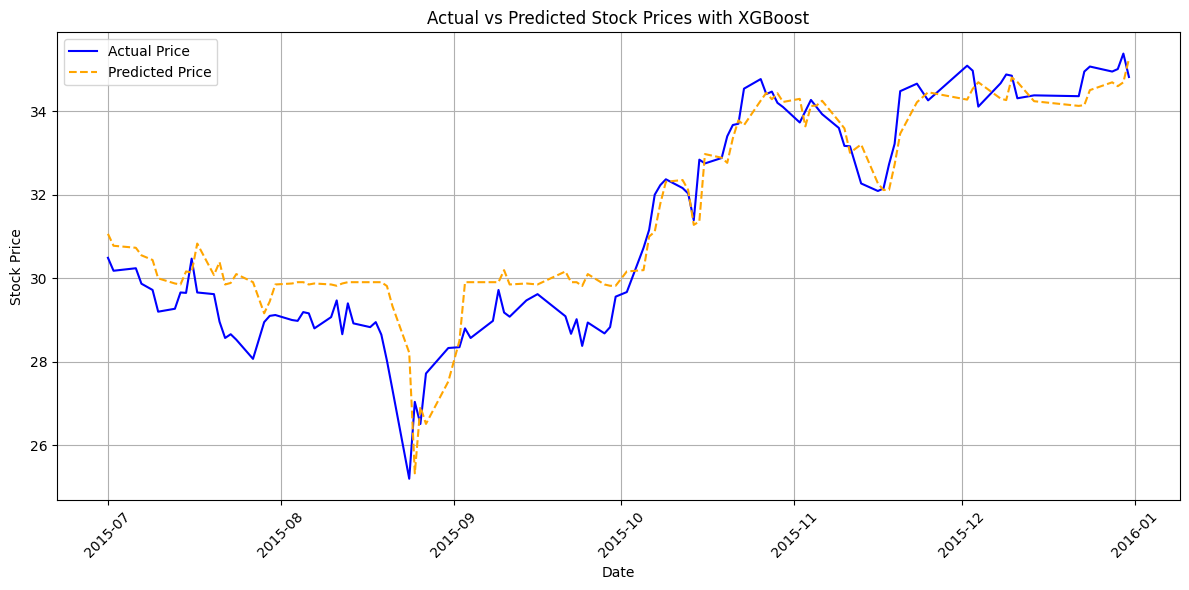

In [751]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt



# 创建滞后特征
merged_data['Price_Lag_1'] = merged_data['Price'].shift(1)
merged_data['Sentiment_Lag_1'] = merged_data['Sentiment'].shift(1)

# 可以添加更多滞后特征
merged_data['Price_Lag_2'] = merged_data['Price'].shift(2)
merged_data['Sentiment_Lag_2'] = merged_data['Sentiment'].shift(2)

# 删除缺失值
merged_data.dropna(inplace=True)

# 定义特征和目标变量
X = merged_data[['Price_Lag_1', 'Price_Lag_2', 'Sentiment_Lag_1', 'Sentiment_Lag_2']]
y = merged_data['Price']

# 划分训练集和测试集
X_train = X[merged_data.index < '2015-07-01']
y_train = y[merged_data.index < '2015-07-01']

X_test = X[merged_data.index >= '2015-07-01']
y_test = y[merged_data.index >= '2015-07-01']

# 定义超参数网格
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}

# 创建 XGBoost 模型
xgb = XGBRegressor(random_state=42)

# 使用 GridSearchCV 进行超参数调优
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# 输出最佳超参数
print("Best Hyperparameters:", grid_search.best_params_)

# 使用最佳参数重新训练模型
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# 预测测试集的股价
y_pred = best_model.predict(X_test)

# 计算均方误差
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

# 创建一个 DataFrame 来保存测试集的实际价格和预测价格
results = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': y_pred
}, index=X_test.index)

# 绘制折线图
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['Actual Price'], label='Actual Price', color='blue')
plt.plot(results.index, results['Predicted Price'], label='Predicted Price', color='orange', linestyle='--')
plt.title('Actual vs Predicted Stock Prices with XGBoost')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [752]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)

mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)


mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


accuracy_matrix = pd.DataFrame({
    'Metric': ['Mean Squared Error', 
               'Root Mean Squared Error', 
               'Mean Absolute Error', 
               'R² Score', 
               'Mean Absolute Percentage Error'],
    'Value': [mse, rmse, mae, r2, mape]
})


accuracy_matrix


,Metric,Value
0,Mean Squared Error,0.705628
1,Root Mean Squared Error,0.840017
2,Mean Absolute Error,0.669576
3,R² Score,0.894089
4,Mean Absolute Percentage Error,2.247985


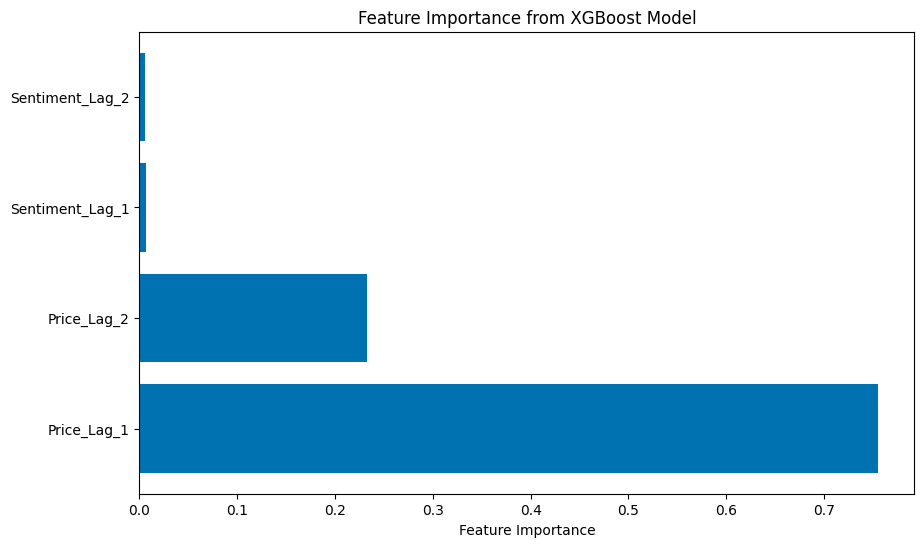

In [753]:
plt.figure(figsize=(10, 6))
plt.barh(range(len(best_model.feature_importances_)), best_model.feature_importances_)
plt.yticks(range(len(best_model.feature_importances_)), X.columns)
plt.xlabel('Feature Importance')
plt.title('Feature Importance from XGBoost Model')
plt.show()

#### RANDOM FOREST

Mean Squared Error: 0.5096


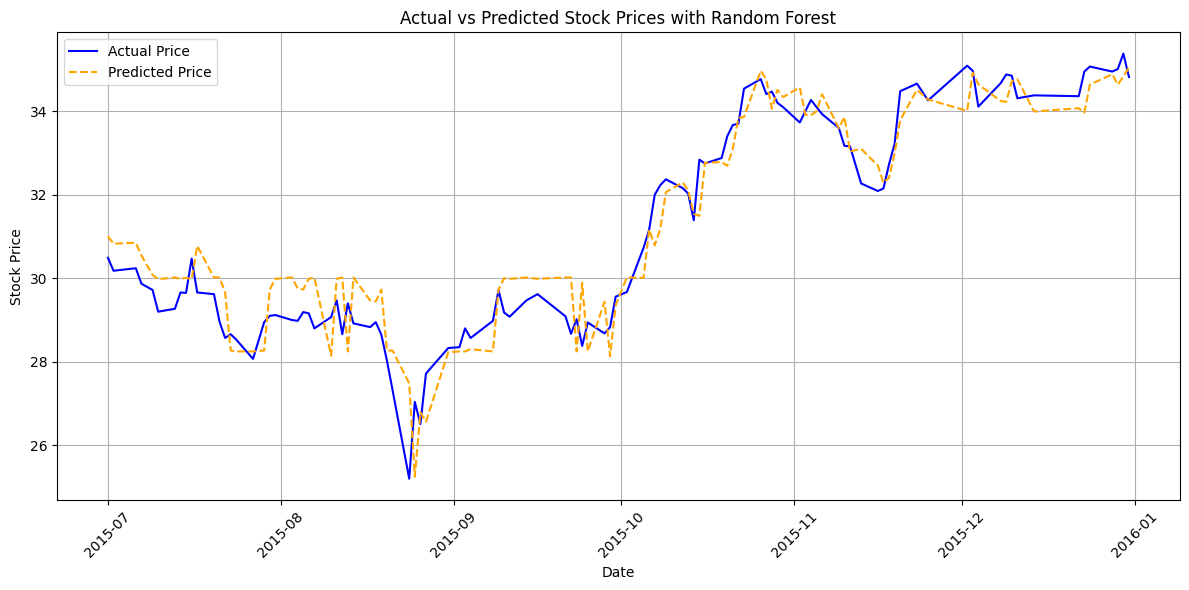

In [754]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 确保 merged_data 已经存在并且是正确的格式
# merged_data['Date'] = pd.to_datetime(merged_data['Date'])
# merged_data.set_index('Date', inplace=True)

# 创建滞后特征
merged_data['Price_Lag_1'] = merged_data['Price'].shift(1)
merged_data['Sentiment_Lag_1'] = merged_data['Sentiment'].shift(1)

# 删除缺失值
merged_data.dropna(inplace=True)

# 定义特征和目标变量
X = merged_data[['Price_Lag_1', 'Sentiment_Lag_1']]
y = merged_data['Price']

# 划分训练集和测试集
X_train = X[merged_data.index < '2015-07-01']
y_train = y[merged_data.index < '2015-07-01']

X_test = X[merged_data.index >= '2015-07-01']
y_test = y[merged_data.index >= '2015-07-01']

# 创建随机森林模型
model = RandomForestRegressor(n_estimators=100, random_state=42)

# 训练模型
model.fit(X_train, y_train)

# 预测测试集的股价
y_pred = model.predict(X_test)

# 计算均方误差
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

# 创建一个 DataFrame 来保存测试集的实际价格和预测价格
results = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': y_pred
}, index=X_test.index)

# 绘制折线图
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['Actual Price'], label='Actual Price', color='blue')
plt.plot(results.index, results['Predicted Price'], label='Predicted Price', color='orange', linestyle='--')
plt.title('Actual vs Predicted Stock Prices with Random Forest')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [755]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 计算均方误差 (MSE)
mse = mean_squared_error(y_test, y_pred)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mse)

# 计算平均绝对误差 (MAE)
mae = mean_absolute_error(y_test, y_pred)

# 计算 R² 分数
r2 = r2_score(y_test, y_pred)

# 计算 MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# 创建准确率矩阵
accuracy_matrix = pd.DataFrame({
    'Metric': ['Mean Squared Error', 
               'Root Mean Squared Error', 
               'Mean Absolute Error', 
               'R² Score', 
               'Mean Absolute Percentage Error'],
    'Value': [mse, rmse, mae, r2, mape]
})

# 输出准确率矩阵
print(accuracy_matrix)


                           Metric     Value
0              Mean Squared Error  0.509649
1         Root Mean Squared Error  0.713897
2             Mean Absolute Error  0.580250
3                        R² Score  0.923504
4  Mean Absolute Percentage Error  1.926075


### Using Time Series Cross Validation

In [756]:
# import pandas as pd
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
# import numpy as np

# # 确保 merged_data 已经存在
# merged_data['Date'] = pd.to_datetime(merged_data['Date'])
# merged_data.set_index('Date', inplace=True)

# 创建滞后特征
merged_data['Price_Lag_1'] = merged_data['Price'].shift(1)
merged_data['Sentiment_Lag_1'] = merged_data['Sentiment'].shift(1)

# 删除缺失值
merged_data.dropna(inplace=True)

# 定义特征和目标变量
X = merged_data[['Price_Lag_1', 'Sentiment_Lag_1']]
y = merged_data['Price']

# 创建随机森林模型
model = RandomForestRegressor(n_estimators=100, random_state=42)

# 设置时间序列交叉验证
tscv = TimeSeriesSplit(n_splits=10)

mse_list = []

# 进行时间序列交叉验证
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # 训练模型
    model.fit(X_train, y_train)
    
    # 预测测试集的股价
    y_pred = model.predict(X_test)
    
    # 计算均方误差
    mse = mean_squared_error(y_test, y_pred)
    mse_list.append(mse)

# 输出每次CV的均方误差
for i, mse in enumerate(mse_list):
    print(f"Fold {i+1} Mean Squared Error: {mse}")

# 输出所有fold的均方误差的平均值
print(f"Average Mean Squared Error over 10 folds: {np.mean(mse_list)}")


Fold 1 Mean Squared Error: 0.20944123693226843
Fold 2 Mean Squared Error: 7.982259778368955
Fold 3 Mean Squared Error: 8.637377081860784
Fold 4 Mean Squared Error: 2.3294613103809514
Fold 5 Mean Squared Error: 0.34626928086915604
Fold 6 Mean Squared Error: 0.4982470360351038
Fold 7 Mean Squared Error: 0.28869850808362263
Fold 8 Mean Squared Error: 0.6498821983881289
Fold 9 Mean Squared Error: 0.5331330218748943
Fold 10 Mean Squared Error: 0.23835364063423403
Average Mean Squared Error over 10 folds: 2.1713123093428104


In [757]:
import pandas as pd

# 生成未来两年的日期数据
future_dates = pd.date_range(start='2017-09-02', periods=365*2, freq='B')  # 业务日
future_df = pd.DataFrame(future_dates, columns=['Date'])
future_df.set_index('Date', inplace=True)

# 生成滞后特征 (假设你需要 1、2、3、5 日的滞后)
future_df['Price_Lag_1'] = None
future_df['Sentiment_Lag_1'] = None
# 此处需要根据模型和历史数据填充滞后特征


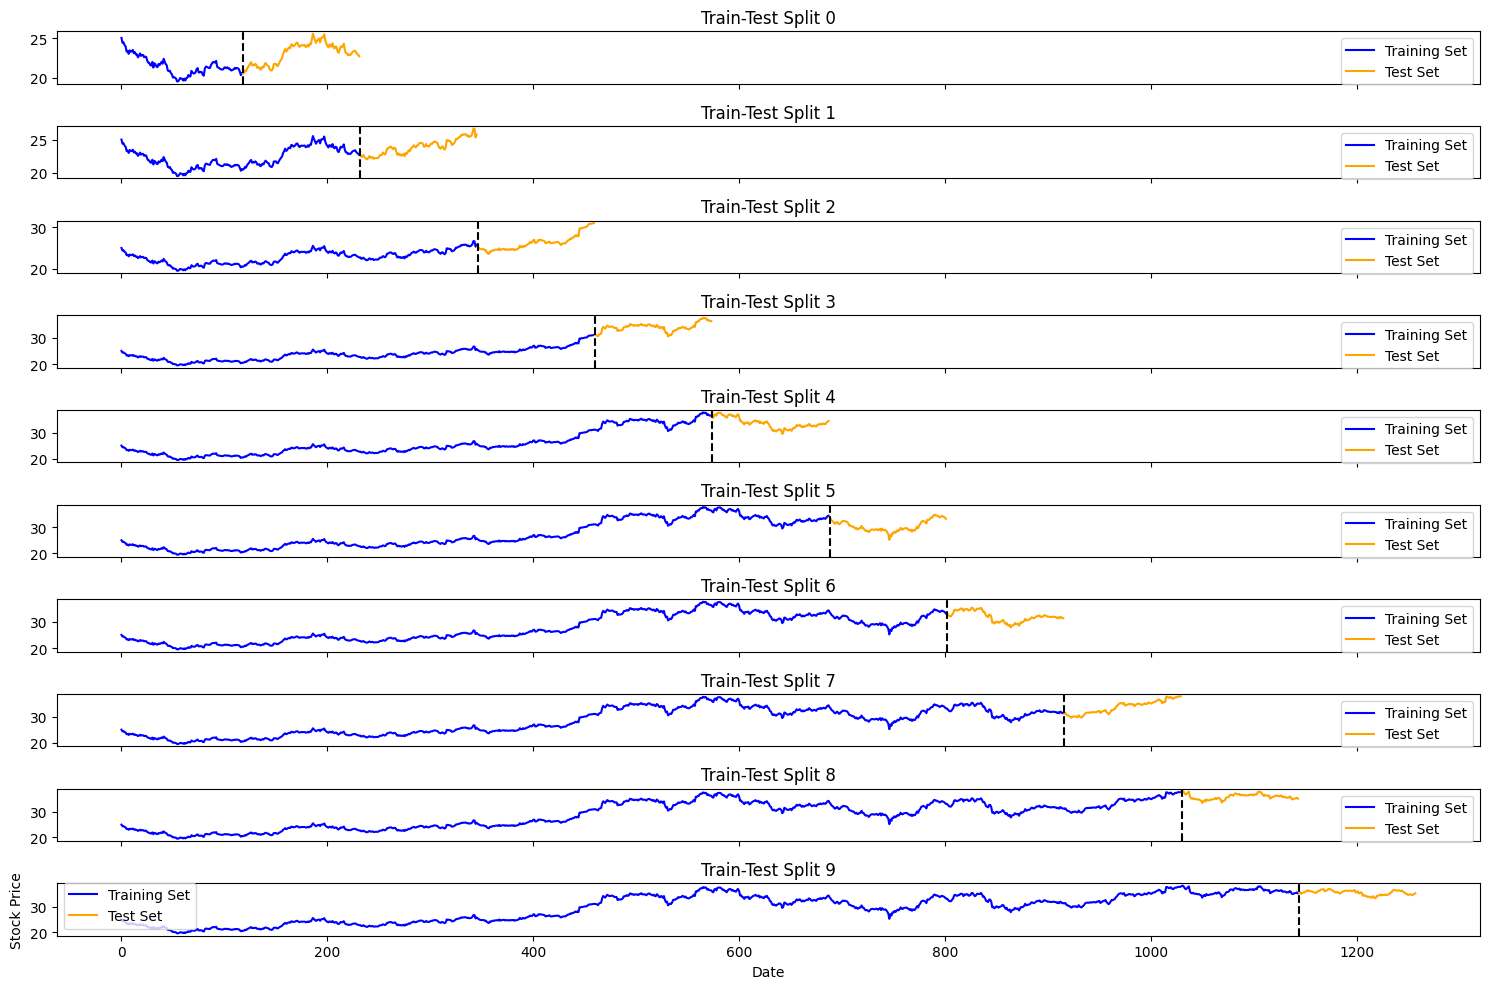

In [758]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Assuming df is your DataFrame
df = df.sort_index()  # Sort by Date if not already sorted

# Initialize the time series split object
tss = TimeSeriesSplit(n_splits=10)

# Create subplots
fig, axs = plt.subplots(10, 1, figsize=(15, 10), sharex=True)

# Loop through each train-test split
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    # Plot the training set
    train['Open'].plot(ax=axs[fold], label='Training Set', color='blue')
    
    # Plot the test set
    test['Open'].plot(ax=axs[fold], label='Test Set', color='orange')
    
    # Add vertical line to indicate the split
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    
    # Title for each fold
    axs[fold].set_title(f'Train-Test Split {fold}')
    axs[fold].legend()
    
    fold += 1

# Set common labels
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.tight_layout()
plt.show()


## Feature Creation

In [759]:
def create_features(df):
    """
    Create time series features given df with datetime index
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

In [760]:
df.set_index('Date', inplace=True)


In [761]:
df = create_features(df)

### Lag Features

#### What was the target x days in the past

In [762]:
def add_lags(df):
    target_map = df['Open'].to_dict()
    pct_map = df['Pct Change'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('1 days')).map(target_map) 
    df['lag2'] = (df.index - pd.Timedelta('2 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('3 days')).map(target_map)
    df['lag5'] = (df.index - pd.Timedelta('5 days')).map(target_map)
    df['Pct_lag_1'] = (df.index - pd.Timedelta('1 days')).map(pct_map)
    return df

In [763]:
df = add_lags(df)

In [764]:
df.tail(5)

,Open,High,Low,Close,Adj Close,Volume,Pct Change,dayofweek,quarter,month,year,lag1,lag2,lag3,lag5,Pct_lag_1
Date,,,,,,,,,,,,,,,,
2017-08-28,34.779999,34.799999,34.590000,34.650002,34.650002,20712900,-0.057675,0,3,8,2017,NaN,NaN,34.820000,34.540001,NaN
2017-08-29,34.509998,34.750000,34.459999,34.730000,34.730000,15843700,0.230874,1,3,8,2017,34.779999,NaN,NaN,34.700001,-0.057675
2017-08-30,34.750000,34.959999,34.630001,34.889999,34.889999,18565000,0.460694,2,3,8,2017,34.509998,34.779999,NaN,34.820000,0.230874
2017-08-31,34.939999,35.180000,34.869999,35.070000,35.070000,16366800,0.515910,3,3,8,2017,34.750000,34.509998,34.779999,NaN,0.460694
2017-09-01,35.240002,35.389999,35.070000,35.090000,35.090000,12818900,0.057029,4,3,9,2017,34.939999,34.750000,34.509998,NaN,0.515910


### Visalising Feature / Target Relationship

In [765]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Pct Change',
       'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2', 'lag3', 'lag5',
       'Pct_lag_1'],
      dtype='object')

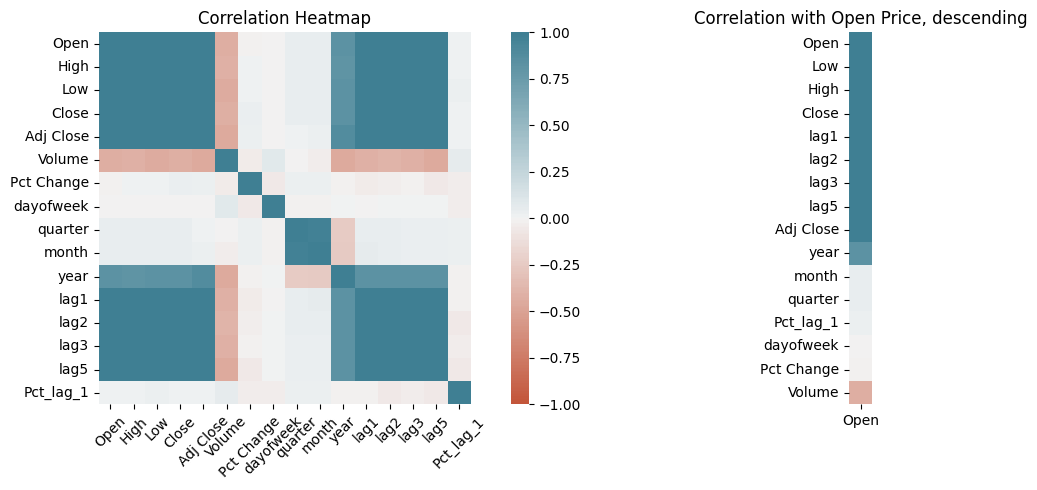

In [766]:
corr = df.corr() 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=-0.5, top=0.9, left=0.1)
ax1 = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200), 
    square=True,
    ax = ax1
)
ax1.set_xticklabels(
    ax1.get_xticklabels(),
    rotation=45,
    # horizontalalignment='right'
)
ax1.set_title('Correlation Heatmap')

# plotting correlation with target
corr_target = df.corr()[['Open']].sort_values(by=['Open'],ascending=False)
ax2 = sns.heatmap(corr_target,
                  vmin=-1, vmax=1, 
                  cmap=sns.diverging_palette(20, 220, n=200),
                  square=True,
                  cbar=False,
                  ax=ax2)
ax2.set_title('Correlation with Open Price, descending');
plt.tight_layout()

We can see that the most strongly correlated variable is high, low, close (which we shouldn't know), but also the lag features and the year

## Model Creation

In [767]:
# 检查缺失值
print(df['Open'].isnull().sum())

# 处理缺失值，可以选择删除或填充
df['Open'].fillna(method='ffill', inplace=True)  # 向前填充
# 或者
# df.dropna(subset=['Open'], inplace=True)  # 删除含缺失值的行



0


In [768]:
adf_test(df['Open'])


NameError: name 'adf_test' is not defined

### Feature Importances

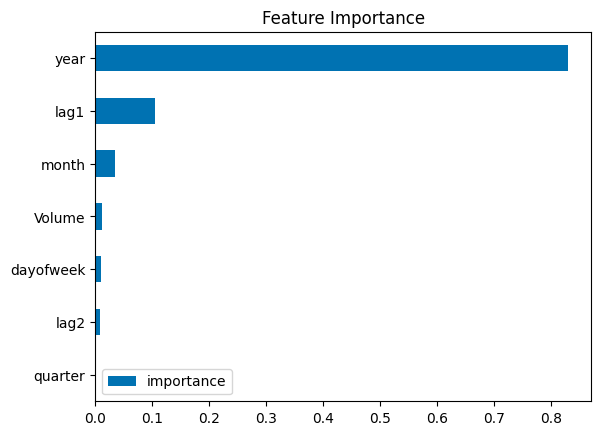

In [99]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [100]:
# predict on test data
test['prediction'] = reg.predict(X_test)

In [101]:
# merging with the df and the test dataset
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

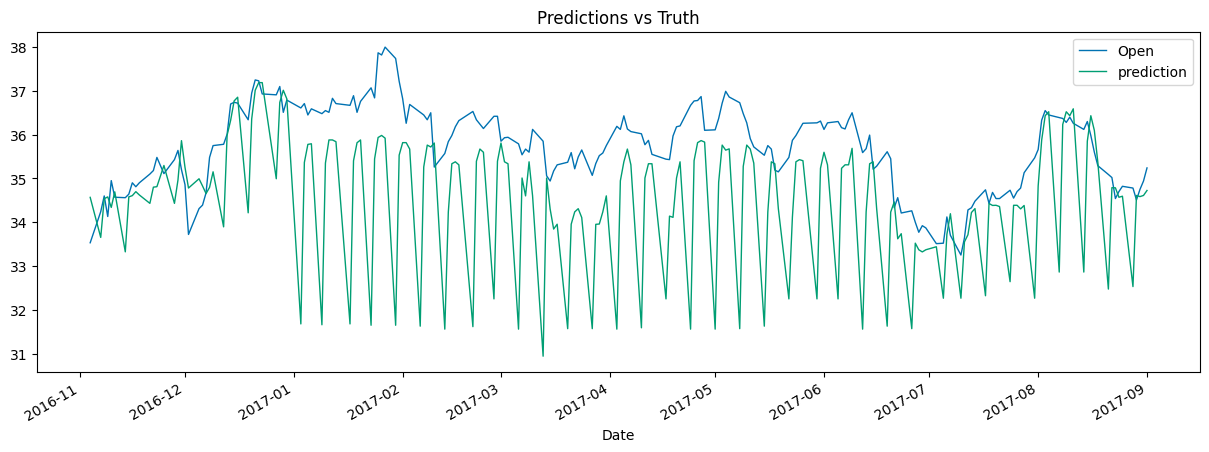

In [102]:
df.loc[(df.index >'11-03-2016')][['Open', 'prediction']] \
    .plot(figsize=(15,5), ms=1, lw=1, title='Predictions vs Truth');